## Credit Card Fraud Detection
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Description of data:

- The dataset is highly <b>unbalanced</b>, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a PCA transformation. 
- Due to confidentiality issues, the original features and more background information about the data is not provided. 
- Features V1, V2, … V28 are the principal components obtained with PCA, the only feature which is not been transformed with PCA is 'Amount'. 
- The feature 'Amount' is the transaction Amount.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Source: [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [1]:
!pip install tabulate
!pip install xgboost

  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
  Using cached xgboost-1.3.2-py3-none-win_amd64.whl (95.2 MB)


In [2]:
# Import required Libraries
import pandas as pd
import numpy as np

# For scaling the features and train-test split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# For model buidling
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# For hyper-paramter tuning
from sklearn.model_selection import GridSearchCV

# For evaluating the model performance
from sklearn.metrics import (f1_score, roc_auc_score,confusion_matrix, accuracy_score,
                             precision_score, recall_score, matthews_corrcoef)


# For reporting the results
from IPython.display import HTML, display
import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read data file
# this file is compressed in bzip2 format and index column is included in it
df = pd.read_csv('creditcard.csv', index_col=False)

##  Undersand the data:

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 30)

In [6]:
df.isnull().sum() # Good No Null Values!

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [8]:
# The classes are heavily skewed. Will this create a problem ? 
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [9]:
# The classes are heavily skewed. This is problem that needs to be solved. How?
print('No Frauds', round(df['Class'].value_counts()[0],2), 'are normal transactions')
print('Frauds', round(df['Class'].value_counts()[1],2), 'are fraud')

No Frauds 284315 are normal transactions
Frauds 492 are fraud


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

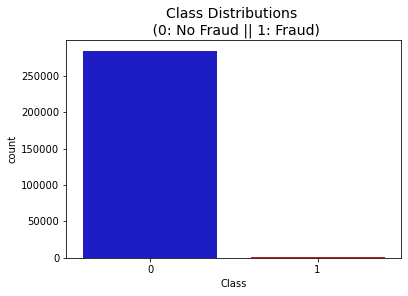

In [10]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

- Notice how imbalanced is our original dataset! 
- Most of the transactions are non-fraud. 
- If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. 
- But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

<h3> Robust Scaling </h3>


**Robust Scaler** scale features using statistics that are robust to outliers. The RobustScaler uses a similar method to the Min-Max scaler but it instead uses the interquartile range, rathar than the min-max, so that it is robust to outliers. 

$$\frac{\text{x}-\text{Q1(x)}}{\text{Q3(x)}-\text{Q1(x)}}$$

In [11]:
# Since most of our data has already been scaled, we will scale the columns that are not scaled (Amount and Time)
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

In [12]:
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [13]:
df.drop(['Amount'], 
        axis=1, 
        inplace=True) # remove original time and Amount Columns from df

In [14]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579


In [15]:
df.scaled_amount.describe()

count    284807.000000
mean          0.927124
std           3.495006
min          -0.307413
25%          -0.229162
50%           0.000000
75%           0.770838
max         358.683155
Name: scaled_amount, dtype: float64

In [16]:
# Rearranging the columns
scaled_amount = df['scaled_amount']

df.drop(['scaled_amount'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)

In [17]:
# Amount and Time are Scaled!
df.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the DataFrame
 

In [18]:
ss = StratifiedShuffleSplit(n_splits=1,
                            test_size=0.2,
                            train_size=0.8,
                            random_state=42)

In [19]:
X = df.drop('Class', axis=1)
y = df['Class']

In [20]:
for train_index, test_index in ss.split(X, y):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

In [21]:
print('Distributions: \n')
print("Train Set")
print(train_df.Class.value_counts())
print("\nTest Set")
print(test_df.Class.value_counts())
print("\nPercentage:")
print("\nTrain Set")
print((train_df.Class.value_counts()/ len(train_df))*100)
print("\nTest Set")
print((test_df.Class.value_counts()/ len(test_df))*100)

Distributions: 

Train Set
0    227451
1       394
Name: Class, dtype: int64

Test Set
0    56864
1       98
Name: Class, dtype: int64

Percentage:

Train Set
0    99.827075
1     0.172925
Name: Class, dtype: float64

Test Set
0    99.827955
1     0.172045
Name: Class, dtype: float64


## Random Under-Sampling:

Implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (randomly picking 394 non-fraud transaction  from 2,27,451 non-fraud transactions)

In [22]:
# Lets shuffle the data before creating the subsamples
train_df = train_df.sample(frac=1)

In [23]:
train_df.Class.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [24]:
# amount of fraud classes 394 rows
fraud_df = train_df.loc[train_df['Class'] == 1]
non_fraud_df = train_df.loc[train_df['Class'] == 0][:394]

In [25]:
fraud_df.shape

(394, 30)

In [26]:
non_fraud_df.shape

(394, 30)

In [27]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

In [28]:
# As fraud_df and non_fraud_df are concatenated, Shuffle dataframe rows to mix the rows
df2 = normal_distributed_df.sample(frac=1, random_state=42)

In [29]:
df2.shape

(788, 30)

In [30]:
df2.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
199957,0.252917,1.934590,-0.244797,-1.028070,0.552106,-0.247268,-0.399541,-0.508807,-0.001507,1.337593,...,-0.093811,0.216382,0.762364,0.047922,0.589203,-0.011929,-0.170737,0.039926,-0.000357,0
84543,6.047928,-3.975216,0.581573,-1.880372,4.319241,-3.024330,1.240793,-1.909559,0.660718,-2.752611,...,-0.656511,0.578984,1.397311,1.045322,-0.304000,0.005295,0.235435,0.962015,-0.673557,1
41943,-0.296793,-2.140511,4.104871,-8.996859,4.028391,-5.131359,-4.153568,-9.360095,1.922075,-4.026180,...,1.725578,1.854267,-0.165534,-0.339939,0.296314,1.364225,-0.518996,2.352333,1.130625,1
64460,1.089779,-11.205461,7.914633,-13.987752,4.333341,-8.484970,-3.506561,-8.935243,7.704449,-2.336584,...,0.860912,0.942593,-0.987848,-0.279446,-0.027299,0.644344,-0.263078,1.084023,0.211933,1
100623,7.364773,-0.758469,-0.045410,-0.168438,-1.313275,-1.901763,0.739433,3.071892,-0.483422,0.618203,...,-0.032500,0.042619,0.397224,0.072229,-0.242276,0.560916,-0.540955,0.150606,-0.117140,1


##  Equally Distributing 
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

In [31]:
print('Distribution of the Classes in the subsample dataset')
print(df2['Class'].value_counts()/len(df2))

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


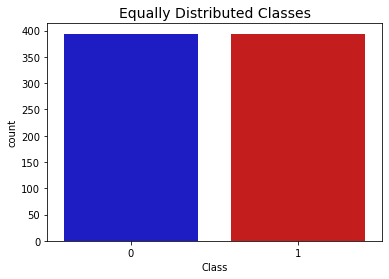

In [32]:
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=df2, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Training the ML Model for Fraud Detection(Classification) 

In [33]:
# Create X_train, X_test, y_train, y_test for ease of use
X_train = df2.drop('Class', axis=1)
y_train = df2['Class']

X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

### 1. SVM:

In [34]:
svm_clf = SVC()

In [35]:
svm_clf.fit(X_train, y_train)

SVC()

In [36]:
def predict_and_evaluate(model, X_test, y_test):
    '''Predict values for given model & test dataset
    and evaluate the results in terms of FP, FN, F1-score,
    Brier Score, AUC and G-Mean'''
    
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    mcc = matthews_corrcoef(y_test,predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    metrics = [fp, fn, round(precision,2), round(recall,2), round(f1,2), round(mcc,2)]
    table = [[model.__class__.__name__] + metrics]
    display(HTML(tabulate.tabulate(table,headers=('Algorithm','False Positives', 
                                                  'False Negatives', 'Precision', 
                                                  'Recall', 'F1 Score', 'MCC'), 
                                   tablefmt='html')))
    #print(accuracy)
    return [model.__class__.__name__] + metrics

In [37]:
svm_res = predict_and_evaluate(svm_clf, X_test, y_test)

Algorithm,False Positives,False Negatives,Precision,Recall,F1 Score,MCC
SVC,1298,10,0.06,0.9,0.12,0.24


## Hyperparamter Optimization

Using [GridSearch](https://scikit-learn.org/stable/modules/grid_search.html)

### 1. SVM:

In [44]:
# Parameter matrix for SVC
svc_params = {'C': [0.5, 0.7, 0.9, 1],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],}

In [45]:
grid_svc = GridSearchCV(SVC(), svc_params, n_jobs = 16)

In [46]:
grid_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=16,
             param_grid={'C': [0.5, 0.7, 0.9, 1],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [47]:
# SVC best parameters
grid_svc.best_params_

{'C': 0.5, 'gamma': 1, 'kernel': 'linear'}

In [48]:
# SVC best estimator
svc = grid_svc.best_estimator_

In [49]:
# predictons
svm_res_hpo = predict_and_evaluate(svc, X_test, y_test)

Algorithm,False Positives,False Negatives,Precision,Recall,F1 Score,MCC
SVC,2416,7,0.04,0.93,0.07,0.18
